# Federated Emotion Recognition - Baseline GPU

students: Ivan Chau (ic2504) and Daniel Garces (dg3008)




## Set-up (specific for Colab)

In [1]:
!pip install tensorflow-gpu

     |████████████████████████████████| 394.3MB 42kB/s 


In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Mon Apr 19 01:58:40 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    23W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Preprocessing Functions

In [5]:
import os
import sys
import csv
import wave
import glob
import math
import itertools
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.fftpack import fft
from scipy.fftpack.realtransforms import dct
from scipy.signal import lfilter, hamming

from tensorflow import keras

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.layers import LSTM, Input, Flatten, Attention, Concatenate, Bidirectional, Embedding, Convolution1D, Dropout
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing import sequence

from sklearn.decomposition import PCA
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.cluster import KMeans

In [6]:
emotions_used = np.array(['ang', 'exc', 'neu', 'sad'])
path = "IEMOCAP_full_release/"
data_path = f"/content/drive/MyDrive/{path}"
sessions = ['Session1', 'Session2', 'Session3', 'Session4', 'Session5']
framerate = 16000
VERBOSE = 1

In [7]:
# Note: All code in this cell is adapted from https://github.com/Samarth-Tripathi/IEMOCAP-Emotion-Detection/

eps = 0.00000001


""" Time-domain audio features """


def stZCR(frame):
    """Computes zero crossing rate of frame"""
    count = len(frame)
    countZ = np.sum(np.abs(np.diff(np.sign(frame)))) / 2
    return (np.float64(countZ) / np.float64(count-1.0))


def stEnergy(frame):
    """Computes signal energy of frame"""
    return np.sum(frame ** 2) / np.float64(len(frame))


def stEnergyEntropy(frame, numOfShortBlocks=10):
    """Computes entropy of energy"""
    Eol = np.sum(frame ** 2)    # total frame energy
    L = len(frame)
    subWinLength = int(np.floor(L / numOfShortBlocks))
    if L != subWinLength * numOfShortBlocks:
            frame = frame[0:subWinLength * numOfShortBlocks]
    # subWindows is of size [numOfShortBlocks x L]
    subWindows = frame.reshape(subWinLength, numOfShortBlocks, order='F').copy()

    # Compute normalized sub-frame energies:
    s = np.sum(subWindows ** 2, axis=0) / (Eol + eps)

    # Compute entropy of the normalized sub-frame energies:
    Entropy = -np.sum(s * np.log2(s + eps))
    return Entropy


""" Frequency-domain audio features """


def stSpectralCentroidAndSpread(X, fs):
    """Computes spectral centroid of frame (given abs(FFT))"""
    ind = (np.arange(1, len(X) + 1)) * (fs/(2.0 * len(X)))

    Xt = X.copy()
    Xt = Xt / Xt.max()
    NUM = np.sum(ind * Xt)
    DEN = np.sum(Xt) + eps

    # Centroid:
    C = (NUM / DEN)

    # Spread:
    S = np.sqrt(np.sum(((ind - C) ** 2) * Xt) / DEN)

    # Normalize:
    C = C / (fs / 2.0)
    S = S / (fs / 2.0)

    return (C, S)


def stSpectralEntropy(X, numOfShortBlocks=10):
    """Computes the spectral entropy"""
    L = len(X)                         # number of frame samples
    Eol = np.sum(X ** 2)            # total spectral energy

    subWinLength = int(np.floor(L / numOfShortBlocks))   # length of sub-frame
    if L != subWinLength * numOfShortBlocks:
        X = X[0:subWinLength * numOfShortBlocks]

    subWindows = X.reshape(subWinLength, numOfShortBlocks, order='F').copy()  # define sub-frames (using matrix reshape)
    s = np.sum(subWindows ** 2, axis=0) / (Eol + eps)                      # compute spectral sub-energies
    En = -np.sum(s*np.log2(s + eps))                                    # compute spectral entropy

    return En


def stSpectralFlux(X, Xprev):
    """
    Computes the spectral flux feature of the current frame
    ARGUMENTS:
        X:        the abs(fft) of the current frame
        Xpre:        the abs(fft) of the previous frame
    """
    # compute the spectral flux as the sum of square distances:
    sumX = np.sum(X + eps)
    sumPrevX = np.sum(Xprev + eps)
    F = np.sum((X / sumX - Xprev/sumPrevX) ** 2)

    return F


def stSpectralRollOff(X, c, fs):
    """Computes spectral roll-off"""
    totalEnergy = np.sum(X ** 2)
    fftLength = len(X)
    Thres = c*totalEnergy
    # Ffind the spectral rolloff as the frequency position where the respective spectral energy is equal to c*totalEnergy
    CumSum = np.cumsum(X ** 2) + eps
    [a, ] = np.nonzero(CumSum > Thres)
    if len(a) > 0:
        mC = np.float64(a[0]) / (float(fftLength))
    else:
        mC = 0.0
    return (mC)


def stHarmonic(frame, fs):
    """
    Computes harmonic ratio and pitch
    """
    M = np.round(0.016 * fs) - 1
    R = np.correlate(frame, frame, mode='full')

    g = R[len(frame)-1]
    R = R[len(frame):-1]

    # estimate m0 (as the first zero crossing of R)
    [a, ] = np.nonzero(np.diff(np.sign(R)))

    if len(a) == 0:
        m0 = len(R)-1
    else:
        m0 = a[0]
    if M > len(R):
        M = len(R) - 1

    Gamma = np.zeros((M), dtype=np.float64)
    CSum = np.cumsum(frame ** 2)
    Gamma[m0:M] = R[m0:M] / (np.sqrt((g * CSum[M:m0:-1])) + eps)

    ZCR = stZCR(Gamma)

    if ZCR > 0.15:
        HR = 0.0
        f0 = 0.0
    else:
        if len(Gamma) == 0:
            HR = 1.0
            blag = 0.0
            Gamma = np.zeros((M), dtype=np.float64)
        else:
            HR = np.max(Gamma)
            blag = np.argmax(Gamma)

        # Get fundamental frequency:
        f0 = fs / (blag + eps)
        if f0 > 5000:
            f0 = 0.0
        if HR < 0.1:
            f0 = 0.0

    return (HR, f0)


def mfccInitFilterBanks(fs, nfft):
    """
    Computes the triangular filterbank for MFCC computation (used in the stFeatureExtraction function before the stMFCC function call)
    This function is taken from the scikits.talkbox library (MIT Licence):
    https://pypi.python.org/pypi/scikits.talkbox
    """

    # filter bank params:
    lowfreq = 133.33
    linsc = 200/3.
    logsc = 1.0711703
    numLinFiltTotal = 13
    numLogFilt = 27

    if fs < 8000:
        nlogfil = 5

    # Total number of filters
    nFiltTotal = numLinFiltTotal + numLogFilt
    #print (str(nFiltTotal))
    #print (str(nfft))

    # Compute frequency points of the triangle:
    freqs = np.zeros(nFiltTotal+2)
    freqs[:numLinFiltTotal] = lowfreq + np.arange(numLinFiltTotal) * linsc
    freqs[numLinFiltTotal:] = freqs[numLinFiltTotal-1] * logsc ** np.arange(1, numLogFilt + 3)
    heights = 2./(freqs[2:] - freqs[0:-2])

    # Compute filterbank coeff (in fft domain, in bins)
    
    
    fbank = np.zeros((int(nFiltTotal), int(nfft)))
    nfreqs = np.arange(nfft) / (1. * nfft) * fs

    for i in range(nFiltTotal):
        lowTrFreq = freqs[i]
        cenTrFreq = freqs[i+1]
        highTrFreq = freqs[i+2]

        lid = np.arange(np.floor(lowTrFreq * nfft / fs) + 1, np.floor(cenTrFreq * nfft / fs) + 1, dtype=np.int)
        lslope = heights[i] / (cenTrFreq - lowTrFreq)
        rid = np.arange(np.floor(cenTrFreq * nfft / fs) + 1, np.floor(highTrFreq * nfft / fs) + 1, dtype=np.int)
        rslope = heights[i] / (highTrFreq - cenTrFreq)
        fbank[i][lid] = lslope * (nfreqs[lid] - lowTrFreq)
        fbank[i][rid] = rslope * (highTrFreq - nfreqs[rid])

    return fbank, freqs


def stMFCC(X, fbank, nceps):
    """
    Computes the MFCCs of a frame, given the fft mag
    ARGUMENTS:
        X:        fft magnitude abs(FFT)
        fbank:    filter bank (see mfccInitFilterBanks)
    RETURN
        ceps:     MFCCs (13 element vector)
    Note:    MFCC calculation is, in general, taken from the scikits.talkbox library (MIT Licence),
    #    with a small number of modifications to make it more compact and suitable for the pyAudioAnalysis Lib
    """

    mspec = np.log10(np.dot(X, fbank.T)+eps)
    ceps = dct(mspec, type=2, norm='ortho', axis=-1)[:nceps]
    return ceps


def stChromaFeaturesInit(nfft, fs):
    """
    This function initializes the chroma matrices used in the calculation of the chroma features
    """
    freqs = np.array([((f + 1) * fs) / (2 * int(nfft)) for f in range(int(nfft))])
    Cp = 27.50

    nChroma = np.round(12.0 * np.log2(freqs / Cp)).astype(int)

    nFreqsPerChroma = np.zeros((nChroma.shape[0], ))

    uChroma = np.unique(nChroma)
    for u in uChroma:
        idx = np.nonzero(nChroma == u)
        nFreqsPerChroma[idx] = idx[0].shape
    return nChroma, nFreqsPerChroma


def stChromaFeatures(X, fs, nChroma, nFreqsPerChroma):
    #TODO: 1 complexity
    #TODO: 2 bug with large windows

    chromaNames = ['A', 'A#', 'B', 'C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#']
    spec = X**2
    C = np.zeros((nChroma.shape[0],))
    C[nChroma] = spec
    C /= nFreqsPerChroma[nChroma]
    finalC = np.zeros((12, 1))
    newD = int(np.ceil(C.shape[0] // 12.0) * 12)
    C2 = np.zeros((newD, ))
    #C2[0:C.shape[0]] = C
    C2 = C2.reshape(int(np.ceil(C2.shape[0]//12)), 12)
    #for i in range(12):
    #    finalC[i] = np.sum(C[i:C.shape[0]:12])
    finalC = np.matrix(np.sum(C2, axis=0)).T
    finalC /= spec.sum()

    return chromaNames, finalC


def stChromagram(signal, Fs, Win, Step, PLOT=False):
    """
    Short-term FFT mag for spectogram estimation:
    Returns:
        a np array (nFFT x numOfShortTermWindows)
    ARGUMENTS:
        signal:      the input signal samples
        Fs:          the sampling freq (in Hz)
        Win:         the short-term window size (in samples)
        Step:        the short-term window step (in samples)
        PLOT:        flag, 1 if results are to be ploted
    RETURNS:
    """
    Win = int(Win)
    Step = int(Step)
    signal = np.double(signal)
    signal = signal / (2.0 ** 15)
    DC = signal.mean()
    MAX = (np.abs(signal)).max()
    signal = (signal - DC) / (MAX - DC)

    N = len(signal)        # total number of signals
    curPos = 0
    countFrames = 0
    nfft = int(Win / 2)
    nChroma, nFreqsPerChroma = stChromaFeaturesInit(nfft, Fs)
    chromaGram = np.array([], dtype=np.float64)

    while (curPos + Win - 1 < N):
        countFrames += 1
        x = signal[curPos:curPos + Win]
        curPos = curPos + Step
        X = abs(fft(x))
        X = X[0:nfft]
        X = X / len(X)
        chromaNames, C = stChromaFeatures(X, Fs, nChroma, nFreqsPerChroma)
        C = C[:, 0]
        if countFrames == 1:
            chromaGram = C.T
        else:
            chromaGram = np.vstack((chromaGram, C.T))
    FreqAxis = chromaNames
    TimeAxis = [(t * Step) / Fs for t in range(chromaGram.shape[0])]

    if (PLOT):
        fig, ax = plt.subplots()
        chromaGramToPlot = chromaGram.transpose()[::-1, :]
        Ratio = chromaGramToPlot.shape[1] / (3*chromaGramToPlot.shape[0])
        chromaGramToPlot = np.repeat(chromaGramToPlot, Ratio, axis=0)
        imgplot = plt.imshow(chromaGramToPlot)
        Fstep = int(nfft / 5.0)
#        FreqTicks = range(0, int(nfft) + Fstep, Fstep)
#        FreqTicksLabels = [str(Fs/2-int((f*Fs) / (2*nfft))) for f in FreqTicks]
        ax.set_yticks(range(Ratio / 2, len(FreqAxis) * Ratio, Ratio))
        ax.set_yticklabels(FreqAxis[::-1])
        TStep = countFrames / 3
        TimeTicks = range(0, countFrames, TStep)
        TimeTicksLabels = ['%.2f' % (float(t * Step) / Fs) for t in TimeTicks]
        ax.set_xticks(TimeTicks)
        ax.set_xticklabels(TimeTicksLabels)
        ax.set_xlabel('time (secs)')
        imgplot.set_cmap('jet')
        plt.colorbar()
        plt.show()

    return (chromaGram, TimeAxis, FreqAxis)


def phormants(x, Fs):
    N = len(x)
    w = np.hamming(N)

    # Apply window and high pass filter.
    x1 = x * w   
    x1 = lfilter([1], [1., 0.63], x1)
    
    # Get LPC.    
    ncoeff = 2 + Fs / 1000
    A, e, k = lpc(x1, ncoeff)    
    #A, e, k = lpc(x1, 8)

    # Get roots.
    rts = np.roots(A)
    rts = [r for r in rts if np.imag(r) >= 0]

    # Get angles.
    angz = np.arctan2(np.imag(rts), np.real(rts))

    # Get frequencies.    
    frqs = sorted(angz * (Fs / (2 * math.pi)))

    return frqs
def beatExtraction(stFeatures, winSize, PLOT=False):
    """
    This function extracts an estimate of the beat rate for a musical signal.
    ARGUMENTS:
     - stFeatures:     a np array (numOfFeatures x numOfShortTermWindows)
     - winSize:        window size in seconds
    RETURNS:
     - BPM:            estimates of beats per minute
     - Ratio:          a confidence measure
    """

    # Features that are related to the beat tracking task:
    toWatch = [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]

    maxBeatTime = int(round(2.0 / winSize))
    HistAll = np.zeros((maxBeatTime,))
    for ii, i in enumerate(toWatch):                                        # for each feature
        DifThres = 2.0 * (np.abs(stFeatures[i, 0:-1] - stFeatures[i, 1::])).mean()    # dif threshold (3 x Mean of Difs)
        [pos1, _] = utilities.peakdet(stFeatures[i, :], DifThres)           # detect local maxima
        posDifs = []                                                        # compute histograms of local maxima changes
        for j in range(len(pos1)-1):
            posDifs.append(pos1[j+1]-pos1[j])
        [HistTimes, HistEdges] = np.histogram(posDifs, np.arange(0.5, maxBeatTime + 1.5))
        HistCenters = (HistEdges[0:-1] + HistEdges[1::]) / 2.0
        HistTimes = HistTimes.astype(float) / stFeatures.shape[1]
        HistAll += HistTimes
        if PLOT:
            plt.subplot(9, 2, ii + 1)
            plt.plot(stFeatures[i, :], 'k')
            for k in pos1:
                plt.plot(k, stFeatures[i, k], 'k*')
            f1 = plt.gca()
            f1.axes.get_xaxis().set_ticks([])
            f1.axes.get_yaxis().set_ticks([])

    if PLOT:
        plt.show(block=False)
        plt.figure()

    # Get beat as the argmax of the agregated histogram:
    I = np.argmax(HistAll)
    BPMs = 60 / (HistCenters * winSize)
    BPM = BPMs[I]
    # ... and the beat ratio:
    Ratio = HistAll[I] / HistAll.sum()

    if PLOT:
        # filter out >500 beats from plotting:
        HistAll = HistAll[BPMs < 500]
        BPMs = BPMs[BPMs < 500]

        plt.plot(BPMs, HistAll, 'k')
        plt.xlabel('Beats per minute')
        plt.ylabel('Freq Count')
        plt.show(block=True)

    return BPM, Ratio


def stSpectogram(signal, Fs, Win, Step, PLOT=False):
    """
    Short-term FFT mag for spectogram estimation:
    Returns:
        a np array (nFFT x numOfShortTermWindows)
    ARGUMENTS:
        signal:      the input signal samples
        Fs:          the sampling freq (in Hz)
        Win:         the short-term window size (in samples)
        Step:        the short-term window step (in samples)
        PLOT:        flag, 1 if results are to be ploted
    RETURNS:
    """
    Win = int(Win)
    Step = int(Step)
    signal = np.double(signal)
    signal = signal / (2.0 ** 15)
    DC = signal.mean()
    MAX = (np.abs(signal)).max()
    signal = (signal - DC) / (MAX - DC)

    N = len(signal)        # total number of signals
    curPos = 0
    countFrames = 0
    nfft = int(Win / 2)
    specgram = np.array([], dtype=np.float64)

    while (curPos + Win - 1 < N):
        countFrames += 1
        x = signal[curPos:curPos+Win]
        curPos = curPos + Step
        X = abs(fft(x))
        X = X[0:nfft]
        X = X / len(X)

        if countFrames == 1:
            specgram = X ** 2
        else:
            specgram = np.vstack((specgram, X))

    FreqAxis = [((f + 1) * Fs) / (2 * nfft) for f in range(specgram.shape[1])]
    TimeAxis = [(t * Step) / Fs for t in range(specgram.shape[0])]

    if (PLOT):
        fig, ax = plt.subplots()
        imgplot = plt.imshow(specgram.transpose()[::-1, :])
        Fstep = int(nfft / 5.0)
        FreqTicks = range(0, int(nfft) + Fstep, Fstep)
        FreqTicksLabels = [str(Fs / 2 - int((f * Fs) / (2 * nfft))) for f in FreqTicks]
        ax.set_yticks(FreqTicks)
        ax.set_yticklabels(FreqTicksLabels)
        TStep = countFrames/3
        TimeTicks = range(0, countFrames, TStep)
        TimeTicksLabels = ['%.2f' % (float(t * Step) / Fs) for t in TimeTicks]
        ax.set_xticks(TimeTicks)
        ax.set_xticklabels(TimeTicksLabels)
        ax.set_xlabel('time (secs)')
        ax.set_ylabel('freq (Hz)')
        imgplot.set_cmap('jet')
        plt.colorbar()
        plt.show()

    return (specgram, TimeAxis, FreqAxis)


""" Windowing and feature extraction """


def stFeatureExtraction(signal, Fs, Win, Step):
    """
    This function implements the shor-term windowing process. For each short-term window a set of features is extracted.
    This results to a sequence of feature vectors, stored in a np matrix.
    ARGUMENTS
        signal:       the input signal samples
        Fs:           the sampling freq (in Hz)
        Win:          the short-term window size (in samples)
        Step:         the short-term window step (in samples)
    RETURNS
        stFeatures:   a np array (numOfFeatures x numOfShortTermWindows)
    """

    Win = int(Win)
    Step = int(Step)

    # Signal normalization
    signal = np.double(signal)

    signal = signal / (2.0 ** 15)
    DC = signal.mean()
    MAX = (np.abs(signal)).max()
    signal = (signal - DC) / MAX

    N = len(signal)                                # total number of samples
    curPos = 0
    countFrames = 0
    nFFT = Win / 2

    [fbank, freqs] = mfccInitFilterBanks(Fs, nFFT)                # compute the triangular filter banks used in the mfcc calculation
    nChroma, nFreqsPerChroma = stChromaFeaturesInit(nFFT, Fs)


    numOfPitches = 5
    numOfPeaks = 10
    numOfTimeSpectralFeatures = 8
    numOfHarmonicFeatures = 0
    nceps = 13
    numOfChromaFeatures = 13

    totalNumOfFeatures = numOfTimeSpectralFeatures + nceps + numOfHarmonicFeatures + numOfChromaFeatures
#    totalNumOfFeatures = numOfTimeSpectralFeatures + nceps + numOfHarmonicFeatures
    stFeatures = np.array([], dtype=np.float64)

    while (curPos + Win - 1 < N):                        # for each short-term window until the end of signal
        countFrames += 1
        x = signal[curPos:curPos+Win]                    # get current window
        curPos = curPos + Step                           # update window position
        X = abs(fft(x))                                  # get fft magnitude
        X = X[0:int(nFFT)]                                    # normalize fft
        X = X / len(X)
        if countFrames == 1:
            Xprev = X.copy()                             # keep previous fft mag (used in spectral flux)
        curFV = np.zeros((totalNumOfFeatures, 1))
        curFV[0] = stZCR(x)                              # zero crossing rate
        curFV[1] = stEnergy(x)                           # short-term energy
        curFV[2] = stEnergyEntropy(x)                    # short-term entropy of energy
        [curFV[3], curFV[4]] = stSpectralCentroidAndSpread(X, Fs)    # spectral centroid and spread
        curFV[5] = stSpectralEntropy(X)                  # spectral entropy
        curFV[6] = stSpectralFlux(X, Xprev)              # spectral flux
        curFV[7] = stSpectralRollOff(X, 0.90, Fs)        # spectral rolloff
        curFV[numOfTimeSpectralFeatures:numOfTimeSpectralFeatures+nceps, 0] = stMFCC(X, fbank, nceps).copy()    # MFCCs

        chromaNames, chromaF = stChromaFeatures(X, Fs, nChroma, nFreqsPerChroma)
        curFV[numOfTimeSpectralFeatures + nceps: numOfTimeSpectralFeatures + nceps + numOfChromaFeatures - 1] = chromaF
        numOfCFFeatures = numOfTimeSpectralFeatures + nceps + numOfChromaFeatures

        curFV[numOfCFFeatures-1] = chromaF.std()
        
        if countFrames == 1:
            stFeatures = curFV                                        # initialize feature matrix (if first frame)
        else:
            stFeatures = np.concatenate((stFeatures, curFV), 1)    # update feature matrix
        Xprev = X.copy()

    return np.array(stFeatures)


def mtFeatureExtraction(signal, Fs, mtWin, mtStep, stWin, stStep):
    """
    Mid-term feature extraction
    """

    mtWinRatio = int(round(mtWin / stStep))
    mtStepRatio = int(round(mtStep / stStep))

    mtFeatures = []

    stFeatures = stFeatureExtraction(signal, Fs, stWin, stStep)
    numOfFeatures = len(stFeatures)
    numOfStatistics = 2

    mtFeatures = []
    #for i in range(numOfStatistics * numOfFeatures + 1):
    for i in range(numOfStatistics * numOfFeatures):
        mtFeatures.append([])

    for i in range(numOfFeatures):        # for each of the short-term features:
        curPos = 0
        N = len(stFeatures[i])
        while (curPos < N):
            N1 = curPos
            N2 = curPos + mtWinRatio
            if N2 > N:
                N2 = N
            curStFeatures = stFeatures[i][N1:N2]

            mtFeatures[i].append(np.mean(curStFeatures))
            mtFeatures[i+numOfFeatures].append(np.std(curStFeatures))
            #mtFeatures[i+2*numOfFeatures].append(np.std(curStFeatures) / (np.mean(curStFeatures)+0.00000010))
            curPos += mtStepRatio

    return np.array(mtFeatures), stFeatures


# TODO
def stFeatureSpeed(signal, Fs, Win, Step):

    signal = np.double(signal)
    signal = signal / (2.0 ** 15)
    DC = signal.mean()
    MAX = (np.abs(signal)).max()
    signal = (signal - DC) / MAX
    # print (np.abs(signal)).max()

    N = len(signal)        # total number of signals
    curPos = 0
    countFrames = 0

    lowfreq = 133.33
    linsc = 200/3.
    logsc = 1.0711703
    nlinfil = 13
    nlogfil = 27
    nceps = 13
    nfil = nlinfil + nlogfil
    nfft = Win / 2
    if Fs < 8000:
        nlogfil = 5
        nfil = nlinfil + nlogfil
        nfft = Win / 2

    # compute filter banks for mfcc:
    [fbank, freqs] = mfccInitFilterBanks(Fs, nfft, lowfreq, linsc, logsc, nlinfil, nlogfil)

    numOfTimeSpectralFeatures = 8
    numOfHarmonicFeatures = 1
    totalNumOfFeatures = numOfTimeSpectralFeatures + nceps + numOfHarmonicFeatures
    #stFeatures = np.array([], dtype=np.float64)
    stFeatures = []

    while (curPos + Win - 1 < N):
        countFrames += 1
        x = signal[curPos:curPos + Win]
        curPos = curPos + Step
        X = abs(fft(x))
        X = X[0:nfft]
        X = X / len(X)
        Ex = 0.0
        El = 0.0
        X[0:4] = 0
#        M = np.round(0.016 * fs) - 1
#        R = np.correlate(frame, frame, mode='full')
        stFeatures.append(stHarmonic(x, Fs))
#        for i in range(len(X)):
            #if (i < (len(X) / 8)) and (i > (len(X)/40)):
            #    Ex += X[i]*X[i]
            #El += X[i]*X[i]
#        stFeatures.append(Ex / El)
#        stFeatures.append(np.argmax(X))
#        if curFV[numOfTimeSpectralFeatures+nceps+1]>0:
#            print curFV[numOfTimeSpectralFeatures+nceps], curFV[numOfTimeSpectralFeatures+nceps+1]
    return np.array(stFeatures)


""" Feature Extraction Wrappers
 - The first two feature extraction wrappers are used to extract long-term averaged
   audio features for a list of WAV files stored in a given category.
   It is important to note that, one single feature is extracted per WAV file (not the whole sequence of feature vectors)
 """


def dirWavFeatureExtraction(dirName, mtWin, mtStep, stWin, stStep, computeBEAT=False):
    """
    This function extracts the mid-term features of the WAVE files of a particular folder.
    The resulting feature vector is extracted by long-term averaging the mid-term features.
    Therefore ONE FEATURE VECTOR is extracted for each WAV file.
    ARGUMENTS:
        - dirName:        the path of the WAVE directory
        - mtWin, mtStep:    mid-term window and step (in seconds)
        - stWin, stStep:    short-term window and step (in seconds)
    """

    allMtFeatures = np.array([])
    processingTimes = []

    types = ('*.wav', '*.aif',  '*.aiff')
    wavFilesList = []
    for files in types:
        wavFilesList.extend(glob.glob(os.path.join(dirName, files)))

    wavFilesList = sorted(wavFilesList)

    for wavFile in wavFilesList:
        [Fs, x] = audioBasicIO.readAudioFile(wavFile)            # read file
        t1 = time.clock()
        x = audioBasicIO.stereo2mono(x)                          # convert stereo to mono
        if computeBEAT:                                          # mid-term feature extraction for current file
            [MidTermFeatures, stFeatures] = mtFeatureExtraction(x, Fs, round(mtWin * Fs), round(mtStep * Fs), round(Fs * stWin), round(Fs * stStep))
            [beat, beatConf] = beatExtraction(stFeatures, stStep)
        else:
            [MidTermFeatures, _] = mtFeatureExtraction(x, Fs, round(mtWin * Fs), round(mtStep * Fs), round(Fs * stWin), round(Fs * stStep))

        MidTermFeatures = np.transpose(MidTermFeatures)
        MidTermFeatures = MidTermFeatures.mean(axis=0)         # long term averaging of mid-term statistics
        if computeBEAT:
            MidTermFeatures = np.append(MidTermFeatures, beat)
            MidTermFeatures = np.append(MidTermFeatures, beatConf)
        if len(allMtFeatures) == 0:                              # append feature vector
            allMtFeatures = MidTermFeatures
        else:
            allMtFeatures = np.vstack((allMtFeatures, MidTermFeatures))
        t2 = time.clock()
        duration = float(len(x)) / Fs
        processingTimes.append((t2 - t1) / duration)
    if len(processingTimes) > 0:
        print("Feature extraction complexity ratio: {0:.1f} x realtime".format((1.0 / np.mean(np.array(processingTimes)))))
    return (allMtFeatures, wavFilesList)


def dirsWavFeatureExtraction(dirNames, mtWin, mtStep, stWin, stStep, computeBEAT=False):
    '''
    Same as dirWavFeatureExtraction, but instead of a single dir it takes a list of paths as input and returns a list of feature matrices.
    EXAMPLE:
    [features, classNames] =
           a.dirsWavFeatureExtraction(['audioData/classSegmentsRec/noise','audioData/classSegmentsRec/speech',
                                       'audioData/classSegmentsRec/brush-teeth','audioData/classSegmentsRec/shower'], 1, 1, 0.02, 0.02);
    It can be used during the training process of a classification model ,
    in order to get feature matrices from various audio classes (each stored in a seperate path)
    '''

    # feature extraction for each class:
    features = []
    classNames = []
    fileNames = []
    for i, d in enumerate(dirNames):
        [f, fn] = dirWavFeatureExtraction(d, mtWin, mtStep, stWin, stStep, computeBEAT=computeBEAT)
        if f.shape[0] > 0:       # if at least one audio file has been found in the provided folder:
            features.append(f)
            fileNames.append(fn)
            if d[-1] == "/":
                classNames.append(d.split(os.sep)[-2])
            else:
                classNames.append(d.split(os.sep)[-1])
    return features, classNames, fileNames


def dirWavFeatureExtractionNoAveraging(dirName, mtWin, mtStep, stWin, stStep):
    """
    This function extracts the mid-term features of the WAVE files of a particular folder without averaging each file.
    ARGUMENTS:
        - dirName:          the path of the WAVE directory
        - mtWin, mtStep:    mid-term window and step (in seconds)
        - stWin, stStep:    short-term window and step (in seconds)
    RETURNS:
        - X:                A feature matrix
        - Y:                A matrix of file labels
        - filenames:
    """

    allMtFeatures = np.array([])
    signalIndices = np.array([])
    processingTimes = []

    types = ('*.wav', '*.aif',  '*.aiff')
    wavFilesList = []
    for files in types:
        wavFilesList.extend(glob.glob(os.path.join(dirName, files)))

    wavFilesList = sorted(wavFilesList)

    for i, wavFile in enumerate(wavFilesList):
        [Fs, x] = audioBasicIO.readAudioFile(wavFile)            # read file
        x = audioBasicIO.stereo2mono(x)                          # convert stereo to mono
        [MidTermFeatures, _] = mtFeatureExtraction(x, Fs, round(mtWin * Fs), round(mtStep * Fs), round(Fs * stWin), round(Fs * stStep))  # mid-term feature

        MidTermFeatures = np.transpose(MidTermFeatures)
#        MidTermFeatures = MidTermFeatures.mean(axis=0)        # long term averaging of mid-term statistics
        if len(allMtFeatures) == 0:                # append feature vector
            allMtFeatures = MidTermFeatures
            signalIndices = np.zeros((MidTermFeatures.shape[0], ))
        else:
            allMtFeatures = np.vstack((allMtFeatures, MidTermFeatures))
            signalIndices = np.append(signalIndices, i * np.ones((MidTermFeatures.shape[0], )))

    return (allMtFeatures, signalIndices, wavFilesList)


# The following two feature extraction wrappers extract features for given audio files, however
# NO LONG-TERM AVERAGING is performed. Therefore, the output for each audio file is NOT A SINGLE FEATURE VECTOR
# but a whole feature matrix.
#
# Also, another difference between the following two wrappers and the previous is that they NO LONG-TERM AVERAGING IS PERFORMED.
# In other words, the WAV files in these functions are not used as uniform samples that need to be averaged but as sequences

def mtFeatureExtractionToFile(fileName, midTermSize, midTermStep, shortTermSize, shortTermStep, outPutFile,
                              storeStFeatures=False, storeToCSV=False, PLOT=False):
    """
    This function is used as a wrapper to:
    a) read the content of a WAV file
    b) perform mid-term feature extraction on that signal
    c) write the mid-term feature sequences to a np file
    """
    [Fs, x] = audioBasicIO.readAudioFile(fileName)            # read the wav file
    x = audioBasicIO.stereo2mono(x)                           # convert to MONO if required
    if storeStFeatures:
        [mtF, stF] = mtFeatureExtraction(x, Fs, round(Fs * midTermSize), round(Fs * midTermStep), round(Fs * shortTermSize), round(Fs * shortTermStep))
    else:
        [mtF, _] = mtFeatureExtraction(x, Fs, round(Fs*midTermSize), round(Fs * midTermStep), round(Fs * shortTermSize), round(Fs * shortTermStep))

    np.save(outPutFile, mtF)                              # save mt features to np file
    if PLOT:
        print("Mid-term np file: " + outPutFile + ".npy saved")
    if storeToCSV:
        np.savetxt(outPutFile+".csv", mtF.T, delimiter=",")
        if PLOT:
            print("Mid-term CSV file: " + outPutFile + ".csv saved")

    if storeStFeatures:
        np.save(outPutFile+"_st", stF)                    # save st features to np file
        if PLOT:
            print("Short-term np file: " + outPutFile + "_st.npy saved")
        if storeToCSV:
            np.savetxt(outPutFile+"_st.csv", stF.T, delimiter=",")    # store st features to CSV file
            if PLOT:
                print("Short-term CSV file: " + outPutFile + "_st.csv saved")


def mtFeatureExtractionToFileDir(dirName, midTermSize, midTermStep, shortTermSize, shortTermStep, storeStFeatures=False, storeToCSV=False, PLOT=False):
    types = (dirName + os.sep + '*.wav', )
    filesToProcess = []
    for files in types:
        filesToProcess.extend(glob.glob(files))
    for f in filesToProcess:
        outPath = f
        mtFeatureExtractionToFile(f, midTermSize, midTermStep, shortTermSize, shortTermStep, outPath, storeStFeatures, storeToCSV, PLOT)

In [8]:
# Note: Most code in this cell is adapted from https://github.com/Samarth-Tripathi/IEMOCAP-Emotion-Detection/

def split_wav(wav, emotions):
    (nchannels, sampwidth, framerate, nframes, comptype, compname), samples = wav

    left = samples[0::nchannels]
    right = samples[1::nchannels]

    frames = []
    for ie, e in enumerate(emotions):
        start = e['start']
        end = e['end']

        e['right'] = right[int(start * framerate):int(end * framerate)]
        e['left'] = left[int(start * framerate):int(end * framerate)]

        frames.append({'left': e['left'], 'right': e['right']})
    return frames


def get_field(data, key):
    return np.array([e[key] for e in data])

def pad_sequence_into_array(Xs, maxlen=None, truncating='post', padding='post', value=0.):

    Nsamples = len(Xs)
    if maxlen is None:
        lengths = [s.shape[0] for s in Xs]    # 'sequences' must be list, 's' must be np array, len(s) return the first dimension of s
        maxlen = np.max(lengths)

    Xout = np.ones(shape=[Nsamples, maxlen] + list(Xs[0].shape[1:]), dtype=Xs[0].dtype) * np.asarray(value, dtype=Xs[0].dtype)
    Mask = np.zeros(shape=[Nsamples, maxlen], dtype=Xout.dtype)
    for i in range(Nsamples):
        x = Xs[i]
        if truncating == 'pre':
            trunc = x[-maxlen:]
        elif truncating == 'post':
            trunc = x[:maxlen]
        else:
            raise ValueError("Truncating type '%s' not understood" % truncating)
        if padding == 'post':
            Xout[i, :len(trunc)] = trunc
            Mask[i, :len(trunc)] = 1
        elif padding == 'pre':
            Xout[i, -len(trunc):] = trunc
            Mask[i, -len(trunc):] = 1
        else:
            raise ValueError("Padding type '%s' not understood" % padding)
    return Xout, Mask


def convert_gt_from_array_to_list(gt_batch, gt_batch_mask=None):

    B, L = gt_batch.shape
    gt_batch = gt_batch.astype('int')
    gts = []
    for i in range(B):
        if gt_batch_mask is None:
            l = L
        else:
            l = int(gt_batch_mask[i, :].sum())
        gts.append(gt_batch[i, :l].tolist())
    return gts

def get_audio(path_to_wav, filename):
    wav = wave.open(path_to_wav + filename, mode="r")
    (nchannels, sampwidth, framerate, nframes, comptype, compname) = wav.getparams()
    content = wav.readframes(nframes)
    samples = np.fromstring(content, dtype=np.int16)
    return (nchannels, sampwidth, framerate, nframes, comptype, compname), samples


def get_transcriptions(path_to_transcriptions, filename):
    f = open(path_to_transcriptions + filename, 'r').read()
    f = np.array(f.split('\n'))
    transcription = {}
    for i in range(len(f) - 1):
        g = f[i]
        i1 = g.find(': ')
        i0 = g.find(' [')
        ind_id = g[:i0]
        ind_ts = g[i1+2:]
        transcription[ind_id] = ind_ts
    return transcription


def get_emotions(path_to_emotions, filename):
    f = open(path_to_emotions + filename, 'r').read()
    f = np.array(f.split('\n'))
    idx = f == ''
    idx_n = np.arange(len(f))[idx]
    emotion = []
    for i in range(len(idx_n) - 2):
        g = f[idx_n[i]+1:idx_n[i+1]]
        head = g[0]
        i0 = head.find(' - ')
        start_time = float(head[head.find('[') + 1:head.find(' - ')])
        end_time = float(head[head.find(' - ') + 3:head.find(']')])
        actor_id = head[head.find(filename[:-4]) + len(filename[:-4]) + 1:
                        head.find(filename[:-4]) + len(filename[:-4]) + 5]
        emo = head[head.find('\t[') - 3:head.find('\t[')]
        vad = head[head.find('\t[') + 1:]

        v = float(vad[1:7])
        a = float(vad[9:15])
        d = float(vad[17:23])
        
        j = 1
        emos = []
        while g[j][0] == "C":
            head = g[j]
            start_idx = head.find("\t") + 1
            evoluator_emo = []
            idx = head.find(";", start_idx)
            while idx != -1:
                evoluator_emo.append(head[start_idx:idx].strip().lower()[:3])
                start_idx = idx + 1
                idx = head.find(";", start_idx)
            emos.append(evoluator_emo)
            j += 1

        emotion.append({'start': start_time,
                        'end': end_time,
                        'id': filename[:-4] + '_' + actor_id,
                        'v': v,
                        'a': a,
                        'd': d,
                        'emotion': emo,
                        'emo_evo': emos})
    return emotion


def read_iemocap():
    data = []
    ids = {}
    for session in sessions:
        path_to_wav = data_path + session + '/dialog/wav/'
        path_to_emotions = data_path + session + '/dialog/EmoEvaluation/'
        path_to_transcriptions = data_path + session + '/dialog/transcriptions/'

        files2 = os.listdir(path_to_wav)

        files = []
        for f in files2:
            if f.endswith(".wav"):
                if f[0] == '.':
                    files.append(f[2:-4])
                else:
                    files.append(f[:-4])
                    

        for f in files:       
            print(f)
            mocap_f = f
            if (f== 'Ses05M_script01_1b'):
                mocap_f = 'Ses05M_script01_1' 
            
            wav = get_audio(path_to_wav, f + '.wav')
            transcriptions = get_transcriptions(path_to_transcriptions, f + '.txt')
            emotions = get_emotions(path_to_emotions, f + '.txt')
            sample = split_wav(wav, emotions)

            for ie, e in enumerate(emotions):
                '''if 'F' in e['id']:
                    e['signal'] = sample[ie]['left']
                else:
                    e['signal'] = sample[ie]['right']'''
                
                e['signal'] = sample[ie]['left']
                e.pop("left", None)
                e.pop("right", None)
                e['transcription'] = transcriptions[e['id']]
                if e['emotion'] in emotions_used:
                    if e['id'] not in ids:
                        data.append(e)
                        ids[e['id']] = 1

                        
    sort_key = get_field(data, "id")
    return np.array(data)[np.argsort(sort_key)]

def calculate_features(frames, freq, options):
    window_sec = 0.2
    window_n = int(freq * window_sec)

    st_f = stFeatureExtraction(frames, freq, window_n, window_n / 2)

    if st_f.shape[1] > 2:
        i0 = 1
        i1 = st_f.shape[1] - 1
        if i1 - i0 < 1:
            i1 = i0 + 1
        
        deriv_st_f = np.zeros((st_f.shape[0], i1 - i0), dtype=float)
        for i in range(i0, i1):
            i_left = i - 1
            i_right = i + 1
            deriv_st_f[:st_f.shape[0], i - i0] = st_f[:, i]
        return deriv_st_f
    elif st_f.shape[1] == 2:
        deriv_st_f = np.zeros((st_f.shape[0], 1), dtype=float)
        deriv_st_f[:st_f.shape[0], 0] = st_f[:, 0]
        return deriv_st_f
    else:
        deriv_st_f = np.zeros((st_f.shape[0], 1), dtype=float)
        deriv_st_f[:st_f.shape[0], 0] = st_f[:, 0]
        return deriv_st_f


## Model Definitions

In [9]:
def plot_confusion_matrix(cm, my_tags, title='Confusion matrix', cmap=plt.cm.Blues):
  """ Plotting the confusion_matrix"""
  plt.rc('figure', figsize=(4, 4), dpi=100)
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(my_tags))
  target_names = my_tags
  plt.xticks(tick_marks, target_names, rotation=45)
  plt.yticks(tick_marks, target_names)

  # add normalized values inside the Confusion matrix
  fmt = '.2f'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')

In [10]:
def lstm_model_speech():
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.InputLayer(input_shape=(100,34)))
  model.add(LSTM(512, return_sequences=True, input_shape=(100, 34)))
  model.add(LSTM(512, return_sequences=False))
  model.add(Dense(512, activation='relu', name='embedding_layer'))
  model.add(Dense(4, activation='softmax'))
  model.compile(loss='categorical_crossentropy',optimizer='adam' ,metrics=['acc'])
  return model

def deep_model_speech():
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.InputLayer(input_shape=(100,34)))
    model.add(Convolution1D(512, 3, activation='relu', input_shape=(100, 34) ) )
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(512, activation='relu', name='embedding_layer'))
    model.add(Dropout(0.2))
    model.add(Dense(4, activation='softmax'))
    model.compile(loss='categorical_crossentropy',optimizer='adam' ,metrics=['acc'])
    return model


def conv_model_speech():
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.InputLayer(input_shape=(100,34)))
    model.add(Convolution1D(512, 3, activation='relu', input_shape=(100,34)))
    model.add(Dropout(0.2))
    model.add(Convolution1D(128, 3, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Convolution1D(128, 3, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Convolution1D(64, 3, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(256, activation='relu', name='embedding_layer'))
    model.add(Dropout(0.2))
    model.add(Dense(4, activation='softmax'))
    model.compile(loss='categorical_crossentropy',optimizer='adam' ,metrics=['acc'])
    return model

## Load IEMOCAP

In [ ]:
data = read_iemocap()
data2 = data

import pickle
with open(data_path + '/'+'data_collected.pickle', 'wb') as handle:
    pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

Ses01M_impro06


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


Ses01M_impro06
Ses01M_script02_2
Ses01M_script02_2
Ses01F_script01_1
Ses01F_script01_1
Ses01F_script03_2
Ses01F_script03_2
Ses01M_script01_1
Ses01M_script01_1
Ses01M_impro02
Ses01M_impro02
Ses01M_script01_3
Ses01M_script01_3
Ses01M_impro03
Ses01F_script01_2
Ses01F_script01_2
Ses01M_impro03
Ses01F_impro06
Ses01M_script01_2
Ses01F_impro06
Ses01M_script01_2
Ses01M_impro01
Ses01M_impro01
Ses01F_script03_1
Ses01F_script03_1
Ses01F_script02_2
Ses01F_script02_2
Ses01M_impro04
Ses01M_impro04
Ses01F_script02_1
Ses01F_impro03
Ses01F_script02_1
Ses01F_impro03
Ses01F_impro01
Ses01F_impro01
Ses01M_script03_1
Ses01M_script03_1
Ses01M_impro05
Ses01M_impro05
Ses01F_impro05
Ses01F_impro05
Ses01F_impro02
Ses01F_impro02
Ses01M_script03_2
Ses01F_script01_3
Ses01F_script01_3
Ses01F_impro07
Ses01F_impro07
Ses01M_script02_1
Ses01M_script02_1
Ses01M_impro07
Ses01M_impro07
Ses01F_impro04
Ses01F_impro04
Ses01M_script03_2
Ses02M_impro01
Ses02F_script03_2
Ses02F_script03_2
Ses02M_impro01
Ses02F_impro05
Ses02M_scr

In [11]:
# Only run this cell if you have already generated the data_collected.pickle file
import pickle
with open(data_path +'data_collected.pickle', 'rb') as handle:
    data2 = pickle.load(handle)

## Split Data into Train/Test

In [12]:
text = []
speech_raw = []
counter = 0
Y=[]

for ses_mod in data2:
    text.append(ses_mod['transcription'])
    Y.append(ses_mod['emotion'])
    x_head = ses_mod['signal']
    st_features = calculate_features(x_head, framerate, None)
    st_features, _ = pad_sequence_into_array(st_features, maxlen=100)
    speech_raw.append( st_features.T )
    counter+=1

speech = np.array(speech_raw)
Y = label_binarize(Y,emotions_used)

MAX_SEQUENCE_LENGTH = 500

tokenizer = Tokenizer()
tokenizer.fit_on_texts(text)

token_tr_X = tokenizer.texts_to_sequences(text)
x_text = []

x_text = sequence.pad_sequences(token_tr_X, maxlen=MAX_SEQUENCE_LENGTH)

x_train_text, x_test_text, y_train_text, y_test_text = train_test_split(x_text, Y, test_size=0.1, random_state=42)
x_train_speech, x_test_speech, y_train_speech, y_test_speech = train_test_split(speech, Y, test_size=0.1, random_state=42)

## Baseline Classifiers

### LSTM model

In [13]:
model_lstm_speech = lstm_model_speech()
model_lstm_speech.summary()

hist_lstm_speech = model_lstm_speech.fit(x_train_speech, y_train_speech, 
                 batch_size=64, epochs=100, verbose=VERBOSE, shuffle = True, 
                 validation_split=0.1)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 512)          1120256   
_________________________________________________________________
lstm_1 (LSTM)                (None, 512)               2099200   
_________________________________________________________________
embedding_layer (Dense)      (None, 512)               262656    
_________________________________________________________________
dense (Dense)                (None, 4)                 2052      
Total params: 3,484,164
Trainable params: 3,484,164
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
63/63 [==============================] - 21s 50ms/step - loss: 1.3890 - acc: 0.3463 - val_loss: 1.3395 - val_acc: 0.3978
Epoch 2/100
63/63 [==============================] - 2s 34ms/step - loss: 1.3625 - acc: 0.3551 - val_loss: 1.34

[INFO] evaluating network...
              precision    recall  f1-score   support

         ang       0.51      0.54      0.53       109
         exc       0.41      0.35      0.38       104
         neu       0.49      0.50      0.50       168
         sad       0.68      0.72      0.70       113

    accuracy                           0.53       494
   macro avg       0.52      0.53      0.52       494
weighted avg       0.52      0.53      0.52       494



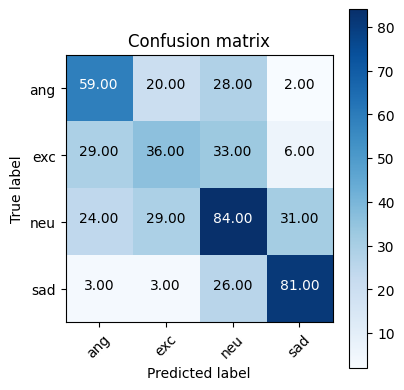

In [14]:
print("[INFO] evaluating network...")
predictions = model_lstm_speech.predict(x=x_test_speech, batch_size=64)

print(classification_report(y_test_speech.argmax(axis=1),
	predictions.argmax(axis=1), target_names=emotions_used))

cm = confusion_matrix(y_test_speech.argmax(axis=1),
	predictions.argmax(axis=1))
plot_confusion_matrix(cm, emotions_used)

### Deep Model

In [15]:
model_deep_speech = deep_model_speech()
model_deep_speech.summary()

hist_deep_speech = model_deep_speech.fit(x_train_speech, Y, 
                 batch_size=64, epochs=100, verbose=VERBOSE, shuffle = True, 
                 validation_split=0.1)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 98, 512)           52736     
_________________________________________________________________
dropout (Dropout)            (None, 98, 512)           0         
_________________________________________________________________
flatten (Flatten)            (None, 50176)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               25690624  
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
embedding_layer (Dense)      (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)              

[INFO] evaluating network...
              precision    recall  f1-score   support

         ang       0.24      0.20      0.22       109
         exc       0.25      0.23      0.24       104
         neu       0.36      0.44      0.39       168
         sad       0.34      0.30      0.32       113

    accuracy                           0.31       494
   macro avg       0.30      0.29      0.29       494
weighted avg       0.31      0.31      0.31       494



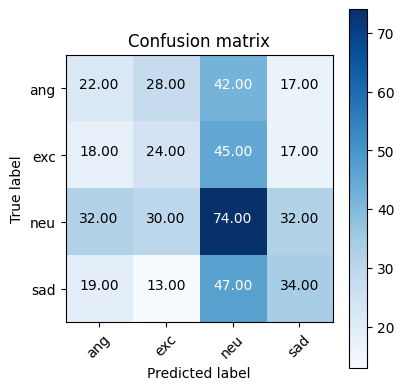

In [16]:
print("[INFO] evaluating network...")
predictions = model_deep_speech.predict(x=x_test_speech, batch_size=64)

print(classification_report(y_test_speech.argmax(axis=1),
	predictions.argmax(axis=1), target_names=emotions_used))

cm = confusion_matrix(y_test_speech.argmax(axis=1),
	predictions.argmax(axis=1))
plot_confusion_matrix(cm, emotions_used)

### Convolutional Model

In [17]:
model_conv_speech = conv_model_speech()

hist_conv_speech = model_conv_speech.fit(x_train_speech, Y, 
                 batch_size=64, epochs=100, verbose=VERBOSE, shuffle = True, 
                 validation_split=0.1)

Epoch 1/100
63/63 [==============================] - 2s 13ms/step - loss: 1.4513 - acc: 0.3094 - val_loss: 1.3887 - val_acc: 0.3236
Epoch 2/100
63/63 [==============================] - 0s 6ms/step - loss: 1.3670 - acc: 0.3433 - val_loss: 1.3802 - val_acc: 0.3236
Epoch 3/100
63/63 [==============================] - 0s 7ms/step - loss: 1.3638 - acc: 0.3520 - val_loss: 1.3847 - val_acc: 0.3169
Epoch 4/100
63/63 [==============================] - 0s 6ms/step - loss: 1.3519 - acc: 0.3580 - val_loss: 1.3822 - val_acc: 0.3213
Epoch 5/100
63/63 [==============================] - 0s 6ms/step - loss: 1.3538 - acc: 0.3542 - val_loss: 1.3784 - val_acc: 0.3169
Epoch 6/100
63/63 [==============================] - 0s 7ms/step - loss: 1.3513 - acc: 0.3434 - val_loss: 1.3870 - val_acc: 0.3236
Epoch 7/100
63/63 [==============================] - 0s 6ms/step - loss: 1.3492 - acc: 0.3524 - val_loss: 1.3989 - val_acc: 0.3034
Epoch 8/100
63/63 [==============================] - 0s 6ms/step - loss: 1.3478 - 

[INFO] evaluating network...
              precision    recall  f1-score   support

         ang       0.24      0.26      0.25       109
         exc       0.22      0.16      0.19       104
         neu       0.33      0.40      0.36       168
         sad       0.26      0.21      0.23       113

    accuracy                           0.28       494
   macro avg       0.26      0.26      0.26       494
weighted avg       0.27      0.28      0.27       494



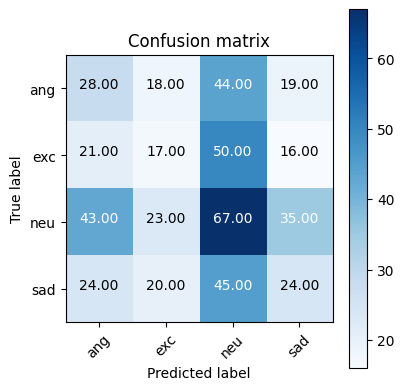

In [18]:
print("[INFO] evaluating network...")
predictions = model_conv_speech.predict(x=x_test_speech, batch_size=64)

print(classification_report(y_test_speech.argmax(axis=1),
	predictions.argmax(axis=1), target_names=emotions_used))

cm = confusion_matrix(y_test_speech.argmax(axis=1),
	predictions.argmax(axis=1))
plot_confusion_matrix(cm, emotions_used)